- title: Visual Introduction to Classification and Logistic Regression
- slug: visual-introduction-classification-logistic-regression-python
- summary: A visual introduction to a classification problem setup and using Logistic Regression in Python
- date: 2018-12-25 9:00  
- category: Machine Learning
- subcategory: Classification
- posttype: Tutorial 
- tags: classification, logistic regression, math
- keywords: visual introduction classification python
- authors: Dan Friedman

The tutorial is a high-level overview of classification problems in machine learning and how Logistic Regression works with a single feature and a binary target. 

I'll cover the following topics:

- Overview of Classification & Key Terms
- Most Popular Classification Algorithms
- Examples of Classification in Industry
- Walkthrough of Credit Card Application Visualizations
- Logistic Regression
- Evaluation Metrics
    - Accuracy
    - Precision & Recall

#### Import Modules

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from collections import Counter
import itertools
import seaborn as sns
import matplotlib.ticker as tick
import matplotlib.patches as patches
import matplotlib.pyplot as plt
% matplotlib inline

#### Visualization Setup

In [2]:
sns.set_context("talk")
sns.set_style("whitegrid", {'grid.color': '.92'})

def reformat_large_tick_values(tick_val, pos):
    """
    Turns large tick values (in the billions, millions and thousands) such as 4500 into 4.5K and also appropriately turns 4000 into 4K (no zero after the decimal).
    """
    if tick_val >= 1000000000:
        val = round(tick_val/1000000000, 1)
        new_tick_format = '{:}B'.format(val)
    elif tick_val >= 1000000:
        val = round(tick_val/1000000, 1)
        new_tick_format = '{:}M'.format(val)
    elif tick_val >= 1000:
        val = round(tick_val/1000, 1)
        new_tick_format = '{:}K'.format(val)
    elif tick_val < 1000:
        new_tick_format = round(tick_val, 1)
    else:
        new_tick_format = tick_val

    # make new_tick_format into a string value
    new_tick_format = str(new_tick_format)

    # code below will keep 4.5M as is but change values such as 4.0M to 4M since that zero after the decimal isn't needed
    index_of_decimal = new_tick_format.find(".")

    if index_of_decimal != -1:
        value_after_decimal = new_tick_format[index_of_decimal+1]
        if value_after_decimal == "0":
            # remove the 0 after the decimal point since it's not needed
            new_tick_format = new_tick_format[0:index_of_decimal] + new_tick_format[index_of_decimal+2:]

    return new_tick_format

### Overview of Classification & Key Terms

#### Problem Setup

Classification involves building a best fit equation to predict the probability an observation is of a certain class/label. Let's break down what some of those terms mean. 

In order to use a classification algorithm, you must be provided with observations, features and labeled data. Let's say we work for a bank and it's our job to approve or deny credit card applicants.

#### Example: Credit Card Application

Most Americans age 18+ likely have a debit or credit card. Credit cards are issued by banks and businesses, allowing the holder to purchase goods or services on credit. Essentially, you can buy items without the exact cash on hand - but in agreement to pay back the bank later. You can learn more about applying for credit cards on <a href='https://www.nerdwallet.com/blog/credit-cards/apply-for-a-credit-card/' rel="nofollow"> Nerdwallet</a>.

To obtain a credit card, you must apply for one through a bank. A bank will decide/classify if you are worthy of the card. 

Below is some fake sample data that indicates important features considered before one is able to be approved for a credit card.

*Credit score*, *debt*, *yearly income*, and *age* are all features. The field for the classification label is *credit card decision*.

Name | Credit Score | Debt (\$) | Yearly Income (\$) | Age | Credit Card Decision
--- | --- | --- | --- | ---- | --- 
Joe Smith | 610 | 3000 | 45000 | 24 | Denied
Jill Mason | 620 | 12000 | 58000 | 22 | Approved
Brandon Cohen | 700 | 0 | 90000 | 27 | Approved
Ariel Pan | 720 | 0 | 110000 | 29 | Approved

There's a small trend that people that have a higher credit score, less debt and more income are more likely to be approved for a particular credit card.

In the table above, each row is considered an **observation**. With each observation as a record of a person, there's additional details on their credit score, debt, yearly income and age.

The columns *Credit Score* and *Debt (\$)*, *Yearly Income (\$)* and *Age* are considered **features**. They are measurable characteristics for each observation. 

The last column in our table is *Credit Card Decision* and represents a **class** or sometimes considered a label. In the past, a representative from the bank would choose to approve or deny each credit card application based on that observation's features. A popular name for this scenario is called <a href='https://en.wikipedia.org/wiki/Labeled_data' rel='nofollow'>labeled data</a>.

#### Binary Classification

In the example above, there were just two possible class labels - either *Denied* or *Approved*. Therefore, this is considered a <a href='https://en.wikipedia.org/wiki/Binary_classification' rel='nofollow'>binary classification</a> example. The term *binary* means related to two things.

#### Multiclass Classification

In machine learning, a <a href='https://en.wikipedia.org/wiki/Multiclass_classification' rel='nofollow'>multiclass classifier</a> is the problem of classifying observations into *three* or more classes. 

### Most Popular Classification Algorithms

These five below I consider *classical* machine learning algorithms -  as many were first profiled tens of years ago.

- Logistic Regression
- SVM
- Naive Bayes
- Decision Trees
- Random Forest

In this notebook, we're just going to learn Logistic Regression. Why? Well Logistic Regression is simple to implement and fits to data quickly. Also, this model is very interpretable -  both in the math with how it works and interpretability of features. Not all other algorithms listed above also fit this criteria.

However, note Logistic Regression is often regarded as one of the simpler classification algorithms. It is just OK at capturing the variance with many features. So, you likely won't get as strong of a fit of a model with it compared to more complex machine learning models like XGBoost or neural networks.

Let's next talk about some additional business scenarios in which classification is commonly used in industry.

### Popular Examples of Classification Models in Industry

- Diagnosed with a certain type of disease
- Spam classification of text comments
- Image classification
    - Hot dog or not hot dog
    - Nudity or not nudity
    - Food safe to eat or not
    - recognize objects on streets for self-driving cars
- Customer churn - essentially will a person continue using an app/service or leave
- Default or not on a credit card

### Visual Derivation of Logistic Regression Equation

Let's continue with our credit card application example. We'll utilize a single feature, *yearly income*, and two class labels of *approved* and *denied*.

In [3]:
yearly_incomes_us_dollars = [12000, 14000, 25000, 28000, 38000, 45000, 50000, 55000, 60000, 66000, 73000, 75000]
credit_card_decisions = ["denied"]*4 + ["approved"] + ["denied"]*2 + ["approved"]*5

In [4]:
application_data = {'yearly_income': yearly_incomes_us_dollars,
        'credit_card_decision': credit_card_decisions
        }
df_credit_card_applications = pd.DataFrame(application_data)

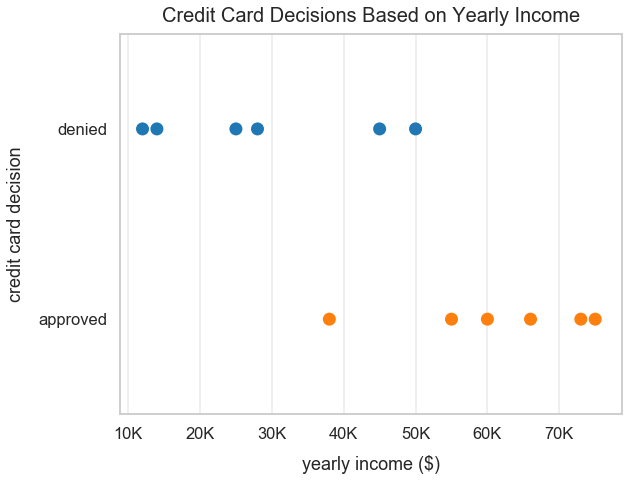

In [5]:
plt.figure(figsize=(9, 7))
sns.stripplot(data=df_credit_card_applications, x="yearly_income", y="credit_card_decision", jitter=False, size=13)
plt.xlabel("yearly income ($)", labelpad=13)
plt.ylabel("credit card decision", labelpad=13)
plt.title("Credit Card Decisions Based on Yearly Income", y=1.015, fontsize=20)
ax = plt.gca()
ax.xaxis.set_major_formatter(tick.FuncFormatter(reformat_large_tick_values));

Upon looking at this graph, I think of a divide in which people that earn over $51,000 per year are more likely to be approved for this credit card. Below, I visualize my first thought with a *Denied Side* and *Approved Side* annotation. 

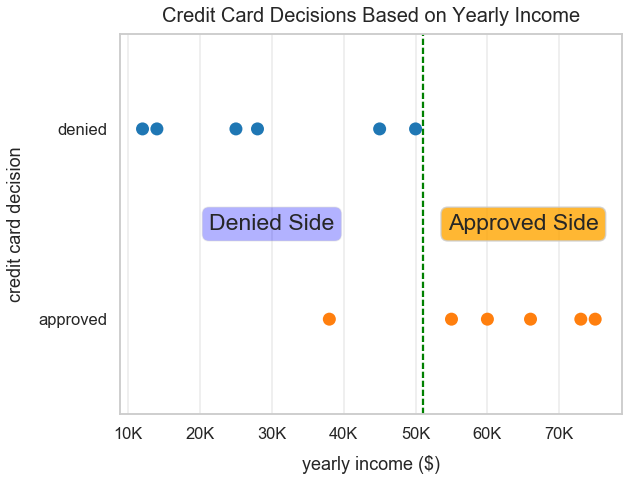

In [6]:
plt.figure(figsize=(9, 7))
ax = sns.stripplot(data=df_credit_card_applications, x="yearly_income", y="credit_card_decision", jitter=False, size=13)
plt.xlabel("yearly income ($)", labelpad=13)
plt.ylabel("credit card decision", labelpad=13)
plt.title("Credit Card Decisions Based on Yearly Income", y=1.015, fontsize=20)
plt.axvline(x=51000, linestyle="--", color='green')
bbox_props_approved = dict(boxstyle="round", fc="orange", ec="0.8", alpha=0.8)
ax.text(65000, 0.5, "Approved Side", ha="center", va="center", size=23, bbox=bbox_props_approved)
bbox_props_denied = dict(boxstyle="round", fc="blue", ec="0.8", alpha=0.3)
ax.text(30000, 0.5, "Denied Side", ha="center", va="center", size=23, bbox=bbox_props_denied)
ax = plt.gca()
ax.xaxis.set_major_formatter(tick.FuncFormatter(reformat_large_tick_values));

#### 2 Features

Let's gather additional data to help us build our best fit of equation to classify whether someone is approved or denied of a credit card.

Below, I incorporated data for people's credit score.

In [7]:
credit_scores = [580, 600, 620, 640, 680, 670, 650, 700, 690, 710, 680, 715]

In [8]:
application_data["credit_score"] = credit_scores
df_credit_card_applications = pd.DataFrame(application_data)

In [9]:
df_credit_card_applications

,yearly_income,credit_card_decision,credit_score
0,12000,denied,580
1,14000,denied,600
2,25000,denied,620
3,28000,denied,640
4,38000,approved,680
5,45000,denied,670
6,50000,denied,650
7,55000,approved,700
8,60000,approved,690
9,66000,approved,710


Let's visualize our two features and two class labels.

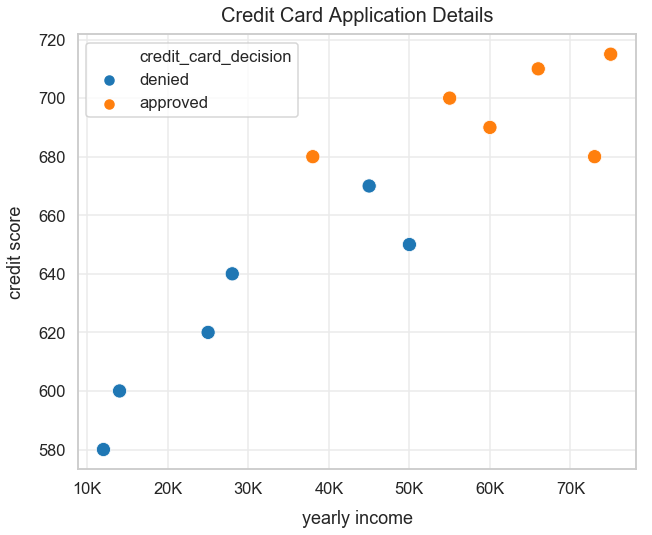

In [10]:
plt.figure(figsize=(10, 8))
sns.scatterplot(x='yearly_income', y='credit_score', hue='credit_card_decision', data=df_credit_card_applications, s=200)
plt.title("Credit Card Application Details", y=1.015, fontsize=20)
plt.xlabel("yearly income", labelpad=13)
plt.ylabel("credit score", labelpad=13)
ax = plt.gca()
ax.xaxis.set_major_formatter(tick.FuncFormatter(reformat_large_tick_values));

#### Visually Predict Which Class a New Observation Belongs To

Below we see a new green plus sign to mark a new observation that doesn't have a labeled class yet. What class do you think it belongs to?

I would classify the new observation as being denied.

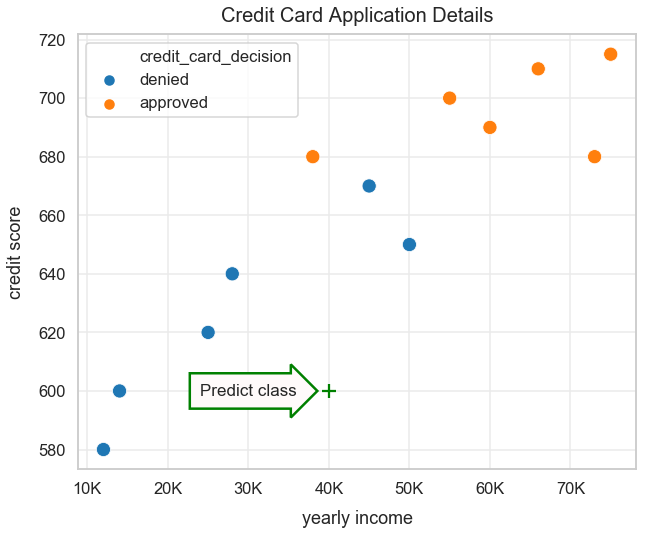

In [11]:
plt.figure(figsize=(10, 8))
ax = sns.scatterplot(x='yearly_income', y='credit_score', hue='credit_card_decision', data=df_credit_card_applications, s=200)
plt.scatter([40000], [600], c='green', s=200, marker='+')
bbox_props = dict(boxstyle="rarrow, pad=0.6", fc="snow", ec="g", lw=2.5)
t = ax.text(30000, 600, "Predict class", ha="center", va="center", size=17, bbox=bbox_props)
plt.title("Credit Card Application Details", y=1.015, fontsize=20)
plt.xlabel("yearly income", labelpad=13)
plt.ylabel("credit score", labelpad=13)
ax = plt.gca()
ax.xaxis.set_major_formatter(tick.FuncFormatter(reformat_large_tick_values));

Below is another example, a purple plus sign, in which we have a new observation but no class label. What class do you think it belongs to?

This one is trickier. There's a decent chance/probability that this observation could be approved or denied. I would hypothesize there's a 0.60 probability that this new observation is denied.

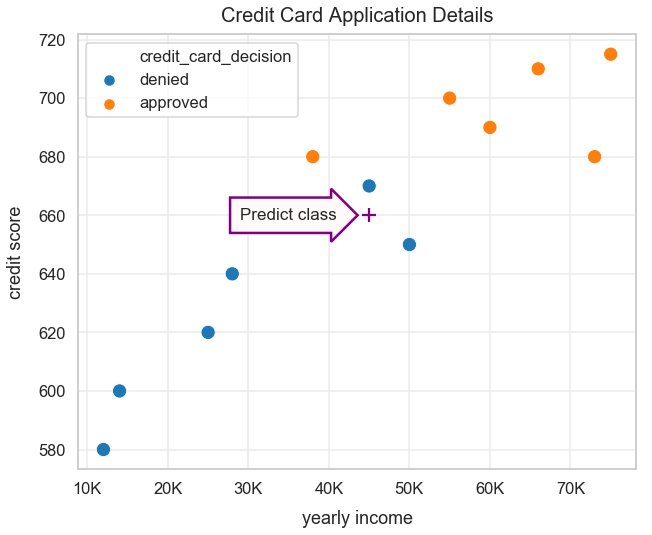

In [12]:
plt.figure(figsize=(10, 8))
ax = sns.scatterplot(x='yearly_income', y='credit_score', hue='credit_card_decision', data=df_credit_card_applications, s=200)
plt.scatter([45000], [660], c='purple', s=200, marker='+')
bbox_props = dict(boxstyle="rarrow, pad=0.6", fc="snow", ec="purple", lw=2.5)
t = ax.text(35000, 660, "Predict class", ha="center", va="center", size=17, bbox=bbox_props)
plt.title("Credit Card Application Details", y=1.015, fontsize=20)
plt.xlabel("yearly income", labelpad=13)
plt.ylabel("credit score", labelpad=13)
ax = plt.gca()
ax.xaxis.set_major_formatter(tick.FuncFormatter(reformat_large_tick_values));

In my mind, I think of a dividing line that would separate the two classes. I plotted one below.

However, this isn't perfect. There's an observation that was approved in my denied side. I figure with additional data points, there will also be more mis-classifications like this one.

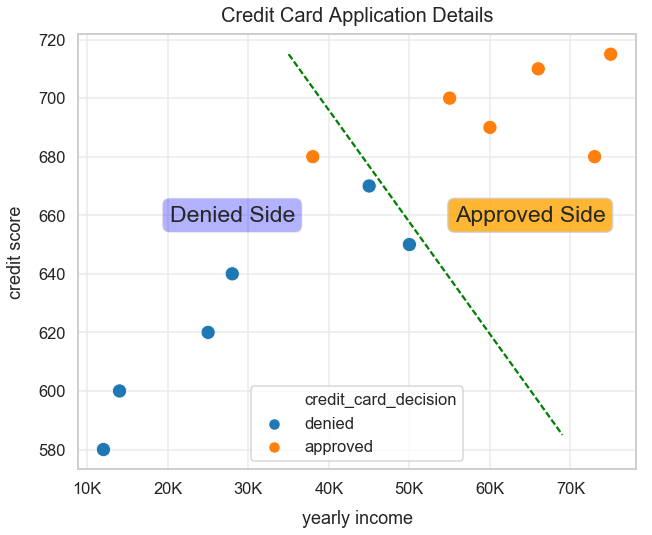

In [13]:
plt.figure(figsize=(10, 8))
ax = sns.scatterplot(x='yearly_income', y='credit_score', hue='credit_card_decision', data=df_credit_card_applications, s=200)
bbox_props_approved = dict(boxstyle="round", fc="orange", ec="0.8", alpha=0.8)
ax.text(65000, 660, "Approved Side", ha="center", va="center", size=23, bbox=bbox_props_approved)
bbox_props_denied = dict(boxstyle="round", fc="blue", ec="0.8", alpha=0.3)
ax.text(28000, 660, "Denied Side", ha="center", va="center", size=23, bbox=bbox_props_denied);
plt.plot([35000, 69000], [715, 585], linestyle="--", color='green')
plt.title("Credit Card Application Details", y=1.015, fontsize=20)
plt.xlabel("yearly income", labelpad=13)
plt.ylabel("credit score", labelpad=13)
ax = plt.gca()
ax.xaxis.set_major_formatter(tick.FuncFormatter(reformat_large_tick_values));

#### Let's Try Linear Regression for Classification

Below I create a new column called `decision_label` that marks a 1 if the `credit_card_decision` is `approved` and a `0` if `denied`.

In [14]:
df_credit_card_applications['decision_label'] = np.where(df_credit_card_applications['credit_card_decision']=="approved", 1, 0)

Preview the DataFrame to visually check our logic is correct.

In [15]:
df_credit_card_applications[['credit_card_decision', 'decision_label']].sample(5)

,credit_card_decision,decision_label
0,denied,0
10,approved,1
7,approved,1
5,denied,0
1,denied,0


We can visualize this new `1` and `0` class label name on a plot below.

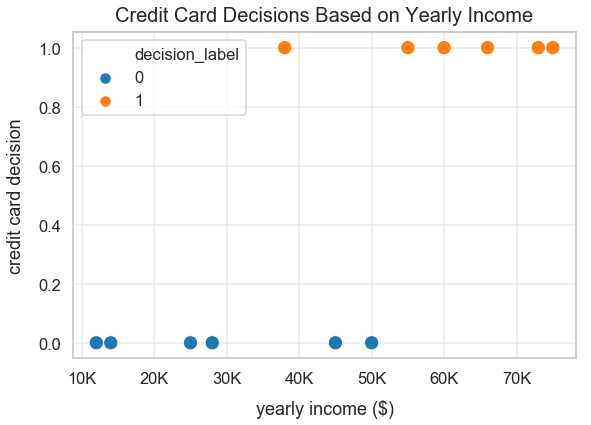

In [16]:
plt.figure(figsize=(9, 6))
sns.scatterplot(x="yearly_income", y="decision_label", hue="decision_label", data=df_credit_card_applications, s=200)
plt.xlabel("yearly income ($)", labelpad=13)
plt.ylabel("credit card decision", labelpad=13)
plt.title("Credit Card Decisions Based on Yearly Income", y=1.015, fontsize=20)
ax = plt.gca()
ax.xaxis.set_major_formatter(tick.FuncFormatter(reformat_large_tick_values));

We'll fit a linear regression model to our entire dataset. First, instantiate the `LinearRegression` object that was imported at the top of our script and assign it to the variable `linear_regression`. You can read more about the <a href='http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html' rel='nofollow'>official documentation</a> of Linear Regression on sklearn.

In [17]:
linear_regression = LinearRegression()

Let's build our linear regression line of best fit and assign it to `lr`. First, we have to get our list of x-values and y-values in the right data format for sklearn.

In [18]:
x_values = df_credit_card_applications['yearly_income'].values.reshape(-1,1)

In [19]:
x_values

array([[12000],
       [14000],
       [25000],
       [28000],
       [38000],
       [45000],
       [50000],
       [55000],
       [60000],
       [66000],
       [73000],
       [75000]])

In [20]:
y_values = df_credit_card_applications['decision_label'].values

In [21]:
y_values

array([0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1])

In [22]:
lr = linear_regression.fit(x_values, y_values)

The coefficient of our linear regression model.

In [23]:
lr.coef_

array([1.83358404e-05])

The intercept of our linear regression model.

In [24]:
lr.intercept_

-0.3266408043702007

Our linear regression line of best fit can be modeled by the equation:

`target = lr.intercept_ + yearly_income * lr.coef_`

Let's plot our linear regression line of best fit using the minimum and maximum values from our x and y axes.

In [25]:
min_income = df_credit_card_applications['yearly_income'].min()
max_income = df_credit_card_applications['yearly_income'].max()

In [26]:
print("min_income: {0}".format(min_income))
print("max_income: {0}".format(max_income))

min_income: 12000
max_income: 75000


We can use the `predict` method to predict a credit card decision value given a yearly annual income value.

In [27]:
lr.predict(min_income)

array([-0.10661072])

Here is our linear regression line of best fit in the range of yearly income values in our dataset.

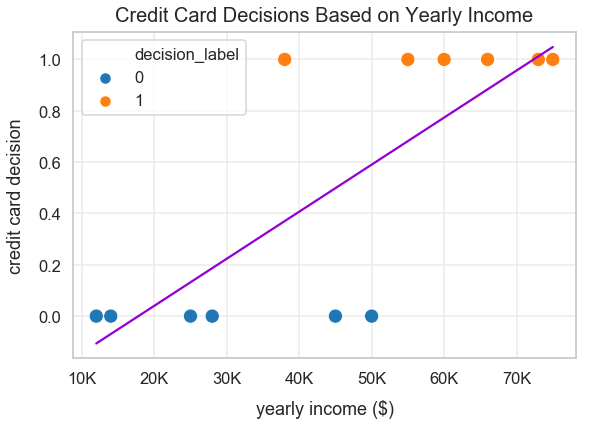

In [28]:
plt.figure(figsize=(9, 6))
sns.scatterplot(x="yearly_income", y="decision_label", hue="decision_label", data=df_credit_card_applications, s=200)
plt.plot([min_income, max_income], [lr.predict(min_income), lr.predict(max_income)], c='darkviolet')
plt.xlabel("yearly income ($)", labelpad=13)
plt.ylabel("credit card decision", labelpad=13)
plt.title("Credit Card Decisions Based on Yearly Income", y=1.015, fontsize=20)
ax = plt.gca()
ax.xaxis.set_major_formatter(tick.FuncFormatter(reformat_large_tick_values));

Below, we calculate our R^2 when trained on the entire dataset. At `0.58`, it's reasonable, but we fail to capture a lot of the variance in our data.

In [29]:
r_squared = lr.score(x_values, y_values)

In [30]:
r_squared

0.5898028659646901

Below, I plot a decision threshold as a dotted green line that's equivalent to `y=0.5`. A **decision threshold** represents the result of a quantitative test to a simple binary decision. 

For example, given an input of a yearly income value, if we get a prediction value greater than `0.5`, we'll simply round up and classify that observation as approved. 

Let's try a yearly income of \$50,000.

In [31]:
lr.predict(50000)

array([0.59015122])

Our returned result of `0.59` is greater than `0.5` so we can round up to `1` and classify this observation as being approved for a credit card.

Now let's try a yearly income of \$33,000.

In [32]:
lr.predict(33000)

array([0.27844193])

Our returned result of `0.27` is less than `0.5` so we can round down to `0` and classify this observation as being rejected for a credit card.

Below, I visualize this decision boundary.


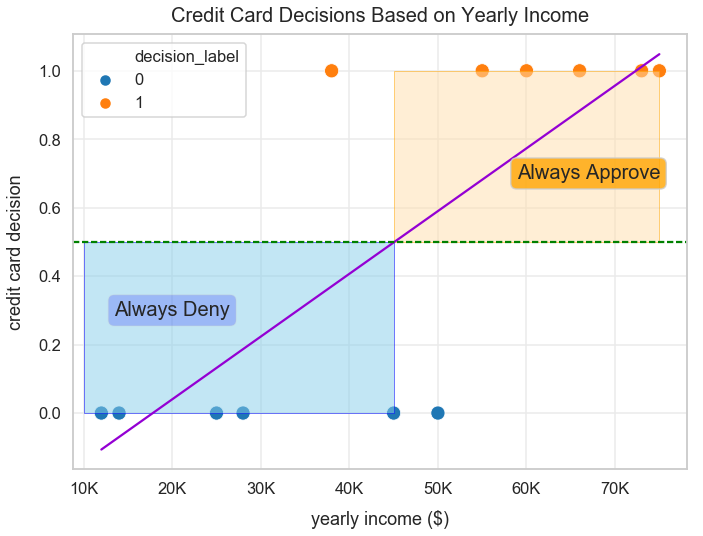

In [33]:
plt.figure(figsize=(11, 8))
sns.scatterplot(x="yearly_income", y="decision_label", hue="decision_label", data=df_credit_card_applications, s=200)
plt.plot([min_income, max_income], [lr.predict(min_income), lr.predict(max_income)], c='darkviolet')
plt.axhline(y=0.5, linestyle="--", color='green')
plt.xlabel("yearly income ($)", labelpad=13)
plt.ylabel("credit card decision", labelpad=13)
plt.title("Credit Card Decisions Based on Yearly Income", y=1.015, fontsize=20)
ax = plt.gca()
orange_rect = patches.Rectangle((45000,0.5), 30000, 0.5, linewidth=1, edgecolor='orange', facecolor='navajowhite', alpha=0.5)
ax.add_patch(orange_rect)
blue_rect = patches.Rectangle((10000, 0), 35000, 0.5, linewidth=1, edgecolor='blue', facecolor='skyblue', alpha=0.5)
ax.add_patch(blue_rect)
bbox_props_approved = dict(boxstyle="round", fc="orange", ec="0.8", alpha=0.8)
ax.text(67000, 0.7, "Always Approve", ha="center", va="center", size=20, bbox=bbox_props_approved)
bbox_props_denied = dict(boxstyle="round", fc="blue", ec="0.8", alpha=0.2)
ax.text(20000, 0.3, "Always Deny", ha="center", va="center", size=20, bbox=bbox_props_denied)
ax.xaxis.set_major_formatter(tick.FuncFormatter(reformat_large_tick_values));

This model clearly isn't perfect. Below, I point to two observations that our model misclassifies given our linear model and rounding up/down logic.

More info on drawing rectangles in Matplotlib: <a href='https://matplotlib.org/api/_as_gen/matplotlib.patches.Rectangle.html#matplotlib.patches.Rectangle' rel='nofollow'>patches.Rectangle documentation page</a>.

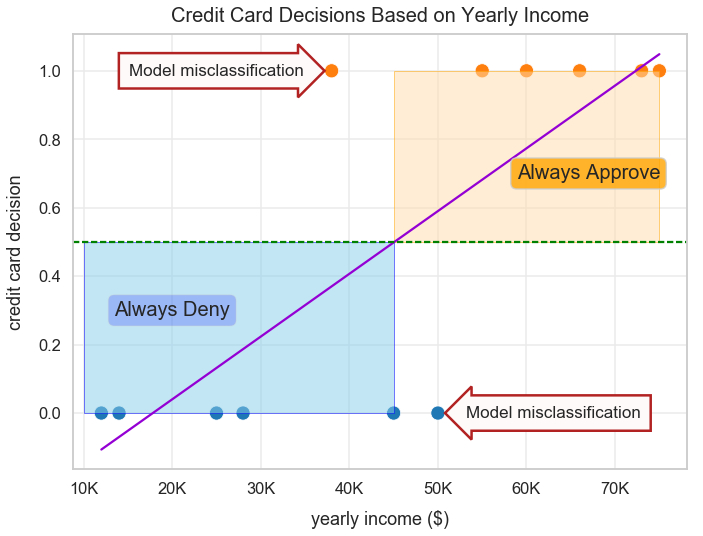

In [34]:
plt.figure(figsize=(11, 8))
sns.scatterplot(x="yearly_income", y="decision_label", hue="decision_label", data=df_credit_card_applications, s=200)
plt.plot([min_income, max_income], [lr.predict(min_income), lr.predict(max_income)], c='darkviolet')
plt.axhline(y=0.5, linestyle="--", color='green')
plt.xlabel("yearly income ($)", labelpad=13)
plt.ylabel("credit card decision", labelpad=13)
plt.title("Credit Card Decisions Based on Yearly Income", y=1.015, fontsize=20)
ax = plt.gca()
orange_rect = patches.Rectangle((45000,0.5), 30000, 0.5, linewidth=1, edgecolor='orange', facecolor='navajowhite', alpha=0.5)
ax.add_patch(orange_rect)
blue_rect = patches.Rectangle((10000, 0), 35000, 0.5, linewidth=1, edgecolor='blue', facecolor='skyblue', alpha=0.5)
ax.add_patch(blue_rect)
bbox_props_approved = dict(boxstyle="round", fc="orange", ec="0.8", alpha=0.8)
ax.text(67000, 0.7, "Always Approve", ha="center", va="center", size=20, bbox=bbox_props_approved)
bbox_props_denied = dict(boxstyle="round", fc="blue", ec="0.8", alpha=0.2)
ax.text(20000, 0.3, "Always Deny", ha="center", va="center", size=20, bbox=bbox_props_denied)
ax.xaxis.set_major_formatter(tick.FuncFormatter(reformat_large_tick_values));
ax.legend_.remove() # removes legend
bbox_props_left = dict(boxstyle="larrow, pad=0.6", fc="snow", ec="firebrick", lw=2.5)
t = ax.text(63000, 0, "Model misclassification", ha="center", va="center", size=17, bbox=bbox_props_left)
bbox_props_left = dict(boxstyle="rarrow, pad=0.6", fc="snow", ec="firebrick", lw=2.5)
t = ax.text(25000, 1, "Model misclassification", ha="center", va="center", size=17, bbox=bbox_props_left)

In [35]:
df_credit_card_applications.head()

,yearly_income,credit_card_decision,credit_score,decision_label
0,12000,denied,580,0
1,14000,denied,600,0
2,25000,denied,620,0
3,28000,denied,640,0
4,38000,approved,680,1


Let's show another reason that a linear regression isn't the best model to fit for this data. I'll now add a single outlier - an individual that applied for this credit card and has a income of \$250,000.

In [36]:
wealthy_person = {'yearly_income': [250000],
        'credit_card_decision': ["approved"],
                  'credit_score': [715],
                  'decision_label': [1]
        }
df_wealthy = pd.DataFrame(wealthy_person)

In [37]:
df_cc_applications_with_outlier = pd.concat([df_credit_card_applications, df_wealthy])

The steps below fit a new linear regression model to our new data that includes this outlier.

In [38]:
linear_regression2 = LinearRegression()
x_values2 = df_cc_applications_with_outlier['yearly_income'].values.reshape(-1,1)
y_values2 = df_cc_applications_with_outlier['decision_label'].values
lr2 = linear_regression2.fit(x_values2, y_values2)

We assign a variable `max_income_outlier` to our new max income value of \$250,000.

In [39]:
max_income_outlier = df_cc_applications_with_outlier['yearly_income'].max()

Our visualization below plots the new linear regression line of best fit with this additional outlier point - the orange dot to the far-most right.

It's clear this line **doesn't** capture the variance in our data well. If we followed the previous decision threshold rules mentioned earlier, we'd likely misclassify more observations moving forward.

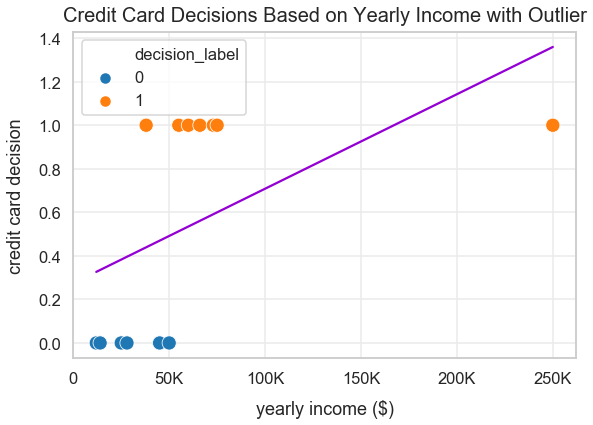

In [40]:
plt.figure(figsize=(9, 6))
sns.scatterplot(x="yearly_income", y="decision_label", hue="decision_label", data=df_cc_applications_with_outlier, s=200)
plt.plot([min_income, max_income_outlier], [lr2.predict(min_income), lr2.predict(max_income_outlier)], c='darkviolet')
plt.xlabel("yearly income ($)", labelpad=13)
plt.ylabel("credit card decision", labelpad=13)
plt.title("Credit Card Decisions Based on Yearly Income with Outlier", y=1.015, fontsize=20)
ax = plt.gca()
ax.xaxis.set_major_formatter(tick.FuncFormatter(reformat_large_tick_values));

Even without this outlier, it's clear this linear regression model doesn't fit to our data well. Let's not use the data with that outlier. Let's take an earlier visualization of our linear regression line of best fit and view it on a larger x and y scale below.

Wow this linear regression seems off! How could someone have a credit card decision greater than `1`? That doesn't make sense since you're either approved or denied, what we marked as `1` or `0`.

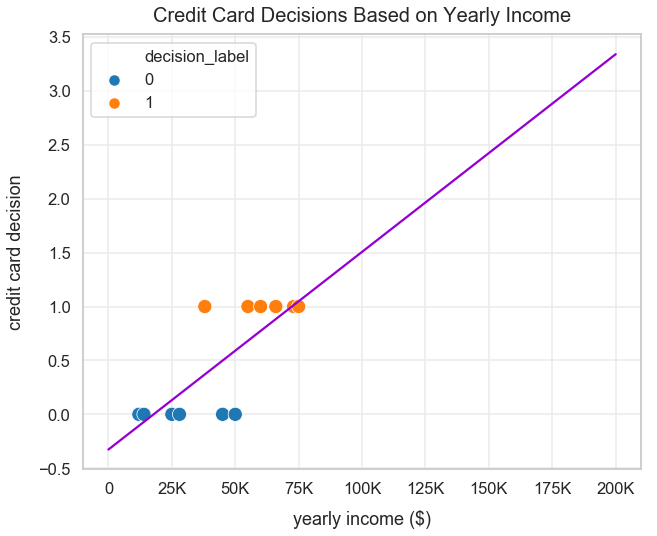

In [41]:
zero_income = 0
super_high_income = 200000
plt.figure(figsize=(10, 8))
sns.scatterplot(x="yearly_income", y="decision_label", hue="decision_label", data=df_credit_card_applications, s=200)
plt.plot([zero_income, super_high_income], [lr.predict(zero_income), lr.predict(super_high_income)], c='darkviolet')
plt.xlabel("yearly income ($)", labelpad=13)
plt.ylabel("credit card decision", labelpad=13)
plt.title("Credit Card Decisions Based on Yearly Income", y=1.015, fontsize=20)
ax = plt.gca()
ax.xaxis.set_major_formatter(tick.FuncFormatter(reformat_large_tick_values));

### Logistic Regression to the Rescue!

We need a better line of fit in order to classify our credit card application data. First, let's learn how the sigmoid function can be relevant.

#### Sigmoid Function

A **sigmoid function** is a mathematical function that represents an "s"-shaped curve. It's defined by the formula:

$$\sigma(x)=\frac{1}{1+e^{-x}}$$

I'll create a list of `x_values` to plot the sigmoid function. The line of code below creates a numpy array of 120 values linearly spaced between -10 and 10. Here's the <a href='https://docs.scipy.org/doc/numpy-1.15.0/reference/generated/numpy.linspace.html' rel='nofollow'>official documentation page</a>.

In [42]:
x_values_for_sigmoid = np.linspace(-10, 10, 120)

Preview the first 5 values of `x_values`.

In [43]:
x_values_for_sigmoid[0:5]

array([-10.        ,  -9.83193277,  -9.66386555,  -9.49579832,
        -9.32773109])

Our sigmoid equation from above wrapped into a Python function.

In [44]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

We can see from the plot below that as `x` increase, the line approaches `1.0` but never reaches it exactly (unless you round up).

Similarly, as `x` decreases, the line approaches `0.0` but never reaches it exactly (unless you round down). 

These limits of this function are exactly what we need to build our line of best fit for a binary classification. This resolves many of the problems we had with using linear regression in this situation.

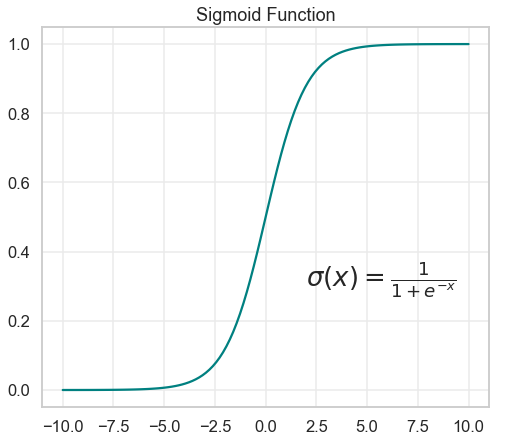

In [45]:
plt.figure(figsize=(8, 7))
plt.plot(x_values_for_sigmoid, sigmoid(x_values_for_sigmoid), c='teal')
plt.title('Sigmoid Function')
plt.grid(True)
plt.text(2, 0.3, r'$\sigma(x)=\frac{1}{1+e^{-x}}$', fontsize=26)
plt.show()

### Logistic Function

Below is the logistic function for a single feature. The denominator looks similar to linear regression with an intercept, coefficient and error value.

$$y_{\beta} (x) = \frac{1}{1+e^{-(\beta_0 + \beta_1 x + \epsilon)}}$$

#### Fit Logistic Regression Model on Credit Card Data

We'd expect a normal distribution with income levels. So, most incomes would be around the mean and median value. I use numpy's `normal` method from the `random` module to generate the data. See the <a href='https://docs.scipy.org/doc/numpy-1.15.0/reference/generated/numpy.random.normal.html' rel='nofollow'>documentation here</a>.

In [46]:
yearly_incomes_us_dollars = np.random.normal(loc=50000, scale=15000, size=500)

/Users/dan/anaconda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


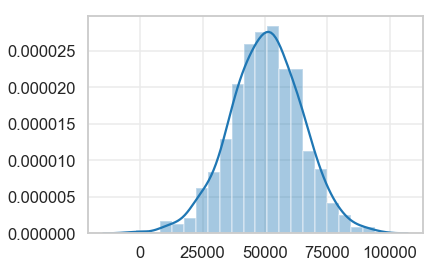

In [47]:
sns.distplot(yearly_incomes_us_dollars)

In [48]:
len(yearly_incomes_us_dollars)

500

I'm going to sort `yearly_income_us_dollars` from least to greatest. 

In [49]:
yearly_incomes_us_dollars = sorted(yearly_incomes_us_dollars)

In [50]:
credit_card_decisions = [0]*180 + [1]*4 + [0]*16 + [1]*5 + [0]*10 + [1]*(500-215)

In [51]:
application_data = {'yearly_income': yearly_incomes_us_dollars,
        'credit_card_decision': credit_card_decisions
        }
df_credit_card_applications2 = pd.DataFrame(application_data)

I want to now see the pattern between income level and credit card decision. I figure people that earn more money generally are accepted more than people who earn less money.

I'll use the Pandas <a href='https://pandas.pydata.org/pandas-docs/stable/generated/pandas.cut.html' rel='nofollow'>cut method</a> to bin income levels by `very low`, `low`, `medium`, `high` and `very high`.

In [52]:
income_bin_labels = pd.cut(df_credit_card_applications2['yearly_income'], bins=5, labels=["very low", "low", "medium", "high", "very high"])

In [53]:
df_credit_card_applications2['income_bucket'] = income_bin_labels

There's an equal number of people in each of the five bins.

In [54]:
df_credit_card_applications2['income_bucket'].value_counts()

medium       245
high         156
low           71
very high     20
very low       8
Name: income_bucket, dtype: int64

Now that our continuous variable (income) is a categorical variable (income level), we can see the mix of the count of credit card decisions by income level. To visualize the data, I use Seaborn's <a href='https://seaborn.pydata.org/generated/seaborn.countplot.html' rel='nofollow'>countplot() method</a>.

Our hypothesis was expected in that wealther individuals are more likely to get accepted for a credit card (decision value of 1) compared to less wealthy people.

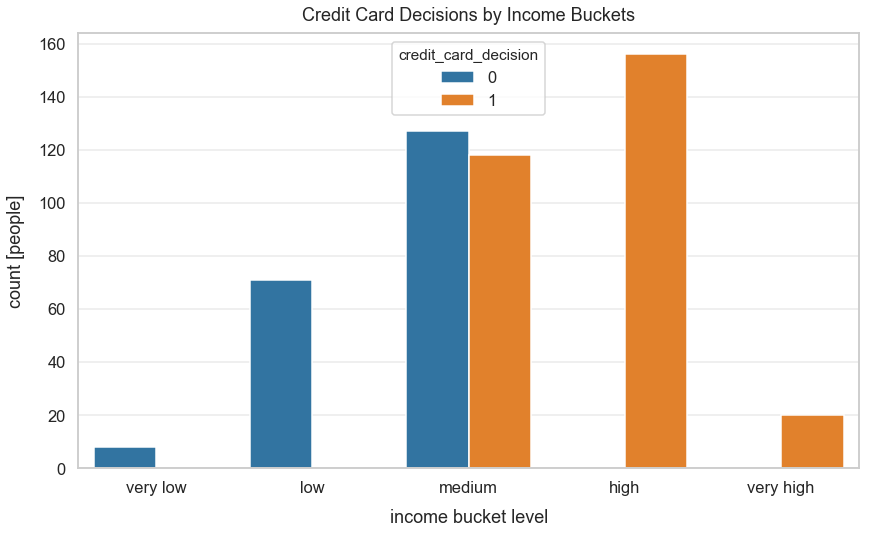

In [55]:
plt.figure(figsize=(14, 8))
sns.countplot(x='income_bucket', hue='credit_card_decision', data=df_credit_card_applications2)
plt.title("Credit Card Decisions by Income Buckets", y=1.015)
plt.ylabel("count [people]", labelpad=13)
plt.xlabel("income bucket level", labelpad=13);

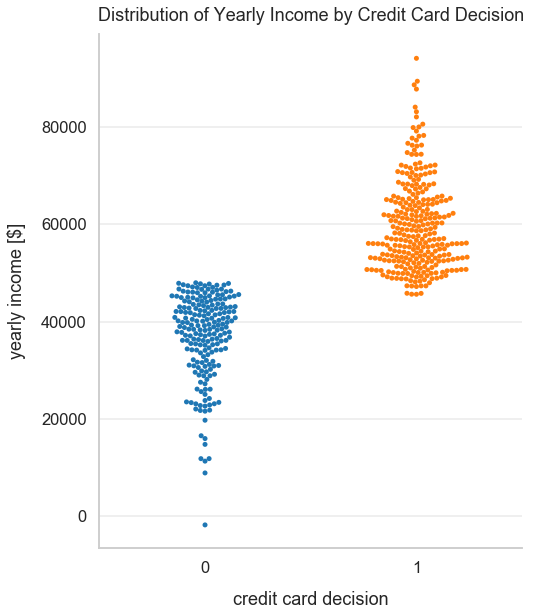

In [56]:
plt.figure(figsize=(14, 8))
sns.catplot(x="credit_card_decision", y="yearly_income", kind="swarm", data=df_credit_card_applications2, height=8.5, aspect=.9)
plt.xlabel("credit card decision", labelpad=15)
plt.ylabel("yearly income [$]", labelpad=15)
plt.title("Distribution of Yearly Income by Credit Card Decision", y=1.013);

In [57]:
X = df_credit_card_applications2['yearly_income'].values.reshape(-1, 1)

We need to standardize our feature `yearly_income` and can do so using <a href='http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html' rel='nofollow'>StandardScaler</a> in sklearn.

Why do we standardize features here? We talked about this in a previous class. Logistic regression by default uses regularization and regularization works best when we standardize our features. Otherwise, if we have outliers, we'll have issues in regularization.

The equation to transform each of our feature values to get a standardized feature value is below. This rescales our features to have a mean of 0 and unit variance - a variance qual to 1.

$$x_{i} = \frac{x_{i} - \bar{x}}{\sigma}$$

In layman's terms, I'd describe this as: for every feature value, subtract the mean of the feature vector and divide that numerator by the standard deviation of the feature vector.

In [58]:
scaler = StandardScaler()

In [59]:
scaler.fit(X)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [60]:
X_transformed = scaler.transform(X)

We can preview a histogram to see the distribution of our new feature-scaled yearly income values.

There's a uniform distribution with a median of roughly 0 and a mean of roughly 0.

/Users/dan/anaconda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


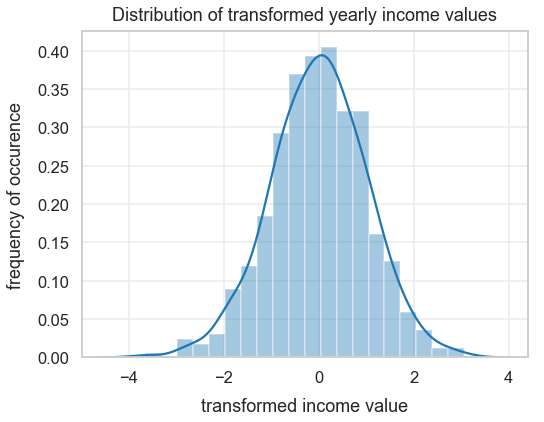

In [61]:
plt.figure(figsize=(8, 6))
sns.distplot(X_transformed)
plt.title("Distribution of transformed yearly income values", y=1.015)
plt.xlabel("transformed income value", labelpad=12)
plt.ylabel("frequency of occurence", labelpad=12);

In [62]:
y = df_credit_card_applications2['credit_card_decision'].values

We will use the Logistic Regression module built into sklearn. Remember to always read the default parameters since this implementation uses regularization. Here is the <a href='http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html' rel='nofollow'>documentation page</a>.

In [63]:
log_reg = LogisticRegression()

Let's do a train-test-split and use 65% of observations for training our model and the other 35% for testing how our model performs on unseen data. The official documentation page for train-test-split is <a href='http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html' rel='nofollow'>here on sklearn</a>.

In [64]:
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.35, random_state=42)

Let's fit our training data to our Logistic Regression object.

In [65]:
log_reg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

#### Visualize Results of Logistic Regression Model Predictions

Our model is fitted. We can now visualize our line of best fit on our training data.

Later, we'll cover model evaluation metrics.

Our `log_reg` object has a `predict_proba()` method. So, if we pass in an x-value (after our feature scaling transformation), we're outputted the probability that observations belongs to class 0 (denied) and class 1 (approved).

In the example below, the first item in that list is the probability that this observation belongs to class 0, and the second list item is the probability this this observation belongs to class 1.

In [66]:
log_reg.predict_proba(X_train)[0]

array([0.71828833, 0.28171167])

I want to create a single array of *just* the probabilities that our model predicts in which each of the observations from our training data belongs to class 1.

In [67]:
X_train_probability_class_1 = log_reg.predict_proba(X_train)[:, 1]

In [68]:
X_train_probability_class_1[0]

0.2817116677754508

To plot the data, I'm going to put our `X_train` observations and `X_train_probability_class_1` predictions as two columns.

In [69]:
predictions = {"x_train_points": X_train.flatten(),
                 "x_train_probability_being_class_1": X_train_probability_class_1}
df_predictions = pd.DataFrame(predictions)

Hey look! It's our plotted predictions and it looks like a sigmoid function!

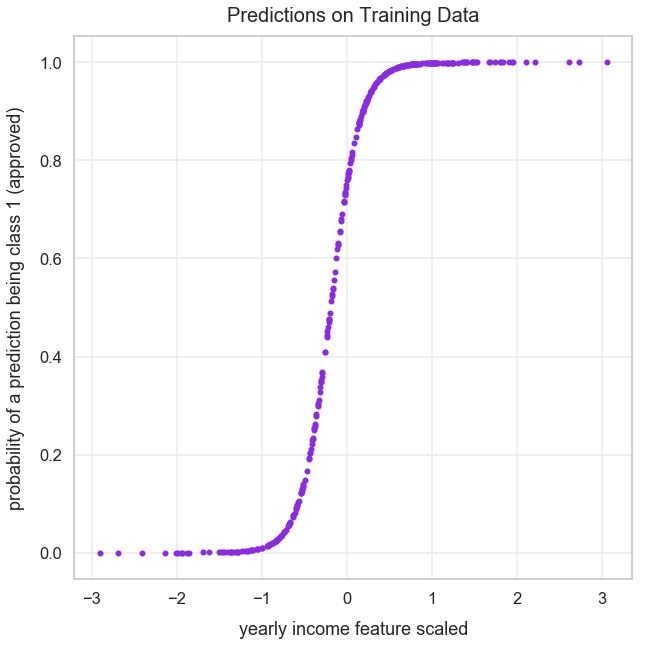

In [70]:
ax = df_predictions.plot.scatter(x="x_train_points", y="x_train_probability_being_class_1", figsize=(10, 10), c='blueviolet')
plt.title("Predictions on Training Data", y=1.015, fontsize=20)
plt.xlabel("yearly income feature scaled", labelpad=14)
plt.ylabel("probability of a prediction being class 1 (approved)", labelpad=14);

So if our logistic regression model outputs a probability between 0 and 1 of an observation belonging to class 1, then how do we classify if the observation belongs to class 0 or class 1? 

As we talked about earlier, you have a **decision threshold**. In binary classification problems in sklearn, there is a default probability decision threshold of 0.5. So, if for an observation we predict a 0.6 probability it belongs to class 1, since 0.6 is greater than 0.5, we'll round up and classify that observation as belonging to class 1.

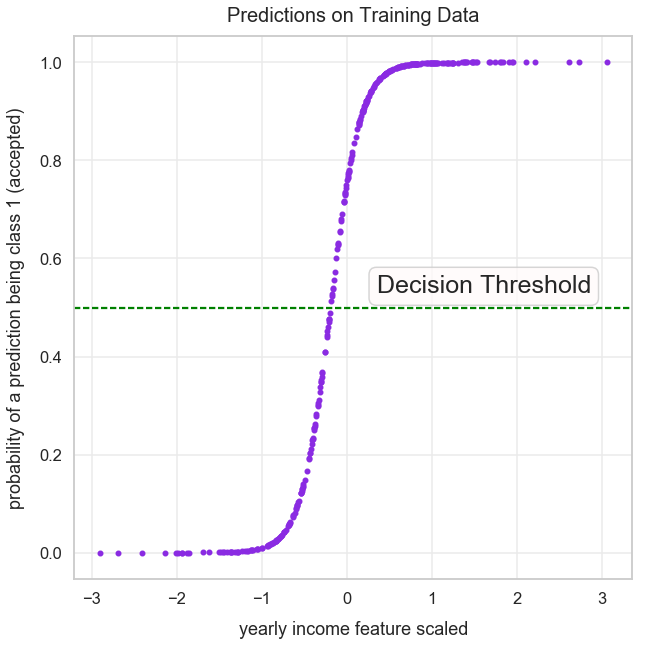

In [71]:
ax = df_predictions.plot.scatter(x="x_train_points", y="x_train_probability_being_class_1", figsize=(10, 10), c='blueviolet')
plt.title("Predictions on Training Data", y=1.015, fontsize=20)
plt.xlabel("yearly income feature scaled", labelpad=14)
plt.ylabel("probability of a prediction being class 1 (accepted)", labelpad=14)
plt.axhline(y=0.5, linestyle="--", color='green')
bbox_props_decision_threshold = dict(boxstyle="round", fc="snow", ec="0.8", alpha=0.8)
ax.text(0.35, 0.53, "Decision Threshold", bbox=bbox_props_decision_threshold, size=25);

Below, I shaded the areas in which if we predict a new observation lies in that area, we'll classify the observation as belonging either to class 0 or class 1.

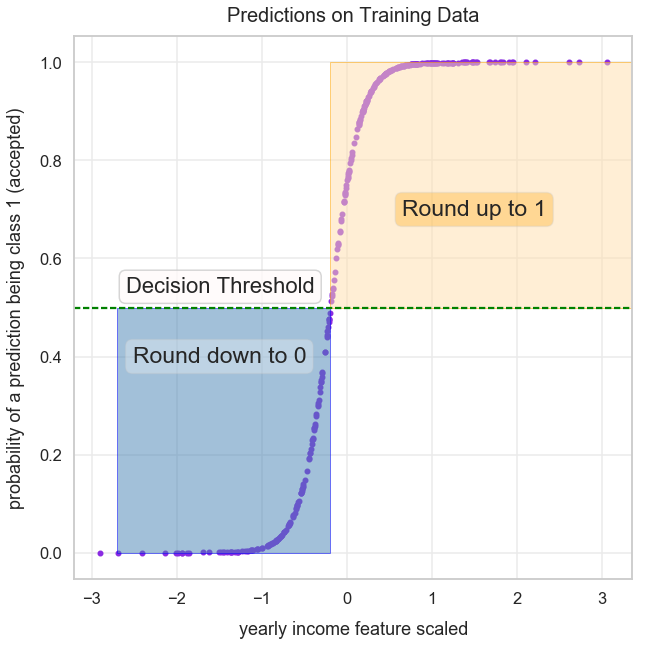

In [72]:
ax = df_predictions.plot.scatter(x="x_train_points", y="x_train_probability_being_class_1", figsize=(10, 10), c='blueviolet')
plt.title("Predictions on Training Data", y=1.015, fontsize=20)
plt.xlabel("yearly income feature scaled", labelpad=14)
plt.ylabel("probability of a prediction being class 1 (accepted)", labelpad=14)
plt.axhline(y=0.5, linestyle="--", color='green')
bbox_props_decision_threshold = dict(boxstyle="round", fc="snow", ec="0.8", alpha=0.8)
ax.text(-2.60, 0.53, "Decision Threshold", bbox=bbox_props_decision_threshold, size=22);

orange_rect = patches.Rectangle((-0.2, 0.5), 3.7, 0.5, linewidth=1, edgecolor='orange', facecolor='navajowhite', alpha=0.5)
ax.add_patch(orange_rect)
bbox_props_approved = dict(boxstyle="round", fc="orange", ec="0.8", alpha=0.3)
ax.text(1.5, 0.7, "Round up to 1", ha="center", va="center", size=23, bbox=bbox_props_approved)

blue_rect = patches.Rectangle((-2.7, 0), 2.5, 0.5, linewidth=1, edgecolor='blue', facecolor='steelblue', alpha=0.5)
ax.add_patch(blue_rect)
bbox_props_denied = dict(boxstyle="round", fc="white", ec="0.8", alpha=0.3)
ax.text(-1.5, 0.4, "Round down to 0", ha="center", va="center", size=23, bbox=bbox_props_denied);

As a hypothetical scenario, we work for this bank, and let's say all of a sudden many people who we give credit cards out to are not paying off their bills in time and so now the bank is low in cash. We don't know the exact underlying reason why this is happening all of a sudden. One hypothesis could be that we've been too lenient about giving out credit cards to people who are on the fence of deserving them. 

We can utilize this knowledge to modify our predictions. Notice how above the probability decision threshold is at 0.5. If we wanted to be pickier about selecting high-quality appilcants for credit cards, we could move our decision threshold up to a value such as 0.7. Then, for our simple example, we'd only approve applicants with a higher income score.

#### Visualize Predictions - Writing our Logistic Regression Prediction Function

Below is the logistic function for a single feature again. 

$$y_{\beta} (x) = \frac{1}{1+e^{-(\beta_0 + \beta_1 x + \epsilon)}}$$

Let's look at our coefficient.

In [73]:
log_reg.coef_

array([[5.76770022]])

Let's look at our intercept.

In [74]:
log_reg.intercept_

array([1.1217481])

We can use the intercept and coefficient from our logistic regression model and simply plug it into the logistic function to visualize our predictions (same as what's above).

In [75]:
def log_reg_model_credit_card_applications_predict(yearly_income):
    return 1 / (1 + np.exp(-(log_reg.intercept_ + log_reg.coef_ * yearly_income)))

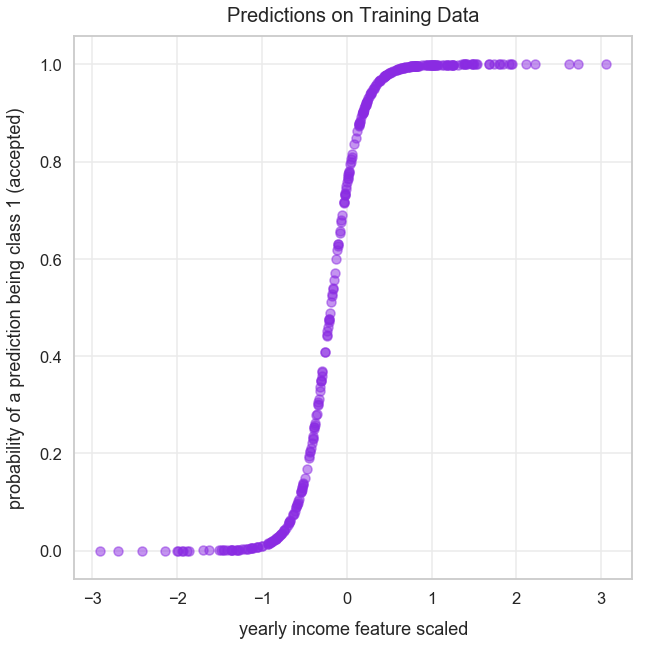

In [76]:
plt.figure(figsize=(10, 10))
plt.scatter(x=X_train, y=log_reg_model_credit_card_applications_predict(X_train), c='blueviolet', alpha=0.5)
plt.title("Predictions on Training Data", y=1.015, fontsize=20)
plt.xlabel("yearly income feature scaled", labelpad=14)
plt.ylabel("probability of a prediction being class 1 (accepted)", labelpad=14);

### Classification Evaluation Metrics

#### Accuracy

**Accuracy** is the proportion of correct predictions. You could also multiply the proportion by 100 to report a percentage value.

Let's view a simplified example of our predictions on an unseen dataset and calculcate accuracy.

Person id | Annual Income in U.S. dollars | Model's prediction of credit card decision | Actual credit card decision
--- | --- | --- | ---
1| 30000 | 0 | 0
2 | 45000 | 0 | 1 
3 | 48000 | 1 | 1
4 | 55000 | 1 | 1
5 | 80000 | 1 | 1

There were 5 total observations. For 4/5 observations, our model predicted a label equivalent to the actual label. 4/5 is 0.8. So we can say the accuracy score of this model is `0.8`. 

In sklearn, for our logistic regression object, which we assigned to `log_reg`, we can use the `score` method and pass in our test data to return an accuracy score.

Typically you report on the accuracy of your model against the test set as a measure for the model's performance.

In [77]:
accuracy_test_set = log_reg.score(X_test, y_test)

In [78]:
accuracy_test_set

0.9714285714285714

I want to round this value to two decimal places. See this <a href='https://stackoverflow.com/questions/455612/limiting-floats-to-two-decimal-points' rel='nofollow'>Stack Overflow article</a> for the method. 

In [79]:
print("{0:.2f}".format(round(accuracy_test_set, 2)))

0.97


There is one major caveat of using accuracy as an evaluation metric of your predictive algorithm. Let's illustrate this caveat through an example. Let's say we're a doctor and we're trying to diagnose people that may have a deadly disease. For most people that come into our office, they *aren't* diagnosed with the disease. 

Below is a sample of the data.

Person id | Age | Family history of disease | Model's disease prediction | Actual diagnosis of disease
--- | --- | --- | --- | ---
1 | 38 | "yes" | "no" | "yes"
2 | 42 | "no" | "no" | "no"
3 | 58 | "yes" | "no" | "no"
4 | 39 | "no" | "no" | "no"
5 | 55 | "no" | "no" | "no"
6 | 61 | "no" | "no" | "no"
7 | 52 | "no" | "no" | "no"
8 | 45 | "no" | "no" | "no"
9 | 59 | "no" | "no" | "no"
10 | 48 | "no" | "no" | "no"

We could build a model with close to 1.0 accuracy by *always* predicting someone doesn't have the disease. But what happens when someone ends up having the disease? If we say they don't, we won't give them the proper care they need to treat the disease. 

This is an example of **imbalanced classes** - since there's more observations of one class than another. You can learn more about how to fix evaluation of models with imbalanced classes through this article on <a href='https://machinelearningmastery.com/tactics-to-combat-imbalanced-classes-in-your-machine-learning-dataset/' rel='nofollow'>Machine Learning Mastery</a>. We won't go into detail on the topic in this tutorial.

#### Confusion Matrix

Below we'll pre-process our data to build a confusion matrix. A **confusion matrix** is a table that describes the performance of a classification model on a set of test data for which the actual labels are known. Let's begin...

Our `X_test` values are meant to utilized to evaluate how our model performs on these unseen inputs. We use our model to make predictions/classify the observations given `X_test`. We assign our list of class predictions to the variable `y_test_predictions`.

In [80]:
y_test_predictions = log_reg.predict(X_test)

As expected, we see a list of 1s and 0s.

In [81]:
y_test_predictions

array([1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0,
       0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0,
       1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0])

We can use <a href='https://docs.python.org/3/library/collections.html#collections.Counter' rel='nofollow'>Counter</a> to create a dictionary of how many predictions are of class 1 versus of class 0.

In [82]:
Counter(y_test_predictions)

Counter({1: 94, 0: 81})

In [83]:
class_names = ["denied", "approved"]

Let's plot our confusion matrix and below we'll explain each element of it. The function below was originally modified from this sklearn <a href='http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py' rel='nofollow'>documentation page</a>. 

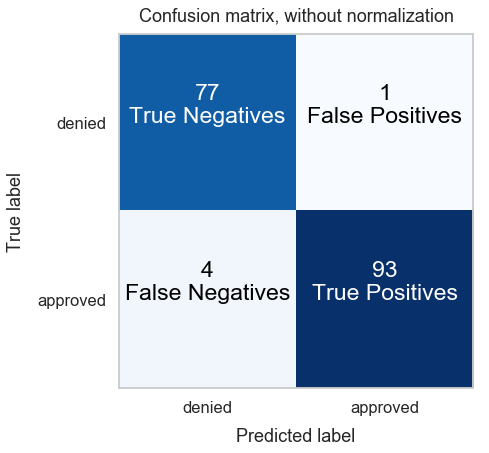

In [84]:
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """        
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)
    
    name = None    
    fmt = 'd'
    thresh = cm.max() / 2
    # i and j tell us the coordinates of boxes
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if i == 0 and j == 0:
            name = "True Negatives"
        elif i == 0 and j == 1:
            name = "False Positives"
        elif i == 1 and j == 1:
            name = "True Positives"
        else:
            name = "False Negatives"
        plt.text(j, i, format(cm[i, j], fmt) + "\n" + name, horizontalalignment="center", 
                 fontsize=23, color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', labelpad=12)
    plt.xlabel('Predicted label', labelpad=12)
    plt.title(title, y=1.02)
    plt.tight_layout()

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_test_predictions);
np.set_printoptions(precision=2);

# Plot non-normalized confusion matrix
plt.figure(figsize=(7, 7))
plt.grid(False)
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion matrix, without normalization')

Our first insights, ignoring the text in the boxes:

- There are two class labels: *approved* and *denied*.
- The x-axis is labeled *Predicted label* - meaning our model's predictions given `X_test`. 
- The y-axis is labeled *True label* - meaning the class labels for our `X_test` observations.
- The model made a total of 175 predictions (equivalent to 75+3+4+93) on if those 175 individuals should be approved or denied of a credit card.
- Out of the 175 predictions, 79 (equivalent to 4 + 75) were for the *denied* class.
- Out of the 175 predictions, 96 (equivalent to 93 + 3) were for the *approved* class.

Let's explain each of the numbers in the boxes:

- For 75 observations (from `X_test`) the model predicted *denied* and the label was actually *denied*.
- For 4 observations (from `X_test`) the model predicted *denied* but the label was actually *approved*.
- For 3 observations (from `X_test`) the model predicted *approved* but the label was actually *denied*.
- For 93 observations (from `X_test`) the model predicted *approved* and it was actually *approved*.

The exact names of True Negatives, False Positives, False Negatives and True Positives will come in handy for other significant evaluation metrics of classification models.

#### Precision

**Precision**: for our predictions of the positive class (*approved* in our example), how often is it correct?

The equation is:

Precision = True Positives / (True Positives + False Positives)

We can manually calculcate precision given the values in the confusion matrix above.

Precision = 93 / (93+3) = 0.96875

In sklearn, we can use the <a href='http://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html' rel='nofollow'>precision_score method</a> from the `metrics` module.

In [85]:
print("Precision: {0}".format(precision_score(y_test, y_test_predictions)))

Precision: 0.9893617021276596


#### Recall

**Recall**: when the actual label is positive (*approved* in our example), how often did we predict correctly?

The equation is:

Recall = True Positives / (True Positives + False Negatives)

We can manually calculate recall given the values in the confusion matrix above.

Recall = 93 / (93 + 4) = 0.96

In sklearn, we can use the <a href='http://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html' rel='nofollow'>recall method</a> from the `metrics` module.

In [86]:
print("Recall:", round(recall_score(y_test, y_test_predictions), 2))

Recall: 0.96
